In [2]:
%env GEOMSTATS_BACKEND=pytorch

env: GEOMSTATS_BACKEND=pytorch


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
sys.path.append("..")  

import os
import numpy as np
import torch
from einops import rearrange
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')


from scipy.spatial.transform import Rotation
from geomstats.geometry.special_orthogonal import SpecialOrthogonal

from utils.plotting import plot_so3
from foldflow.utils.so3_helpers import norm_SO3, expmap, exp, hat
from utils.so3_cfm import SO3SFM
from utils.optimal_transport import so3_wasserstein as wasserstein

from torch.utils.data import DataLoader
from data.datasets import SpecialOrthogonalGroup

from geomstats._backend import _backend_config as _config
_config.DEFAULT_DTYPE = torch.cuda.FloatTensor 

savedir = "models/so3_synthetic"
os.makedirs(savedir, exist_ok=True)

os.environ["CUDA_VISIBLE_DEVICES"] = "5"


/mnt/data/wuhl/anaconda3/envs/foldflow/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO: Using pytorch backend
INFO: Note: detected 232 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO: Note: NumExpr detected 232 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
INFO: NumExpr defaulting to 16 threads.


cuda:0
size of toy dataset:  50000


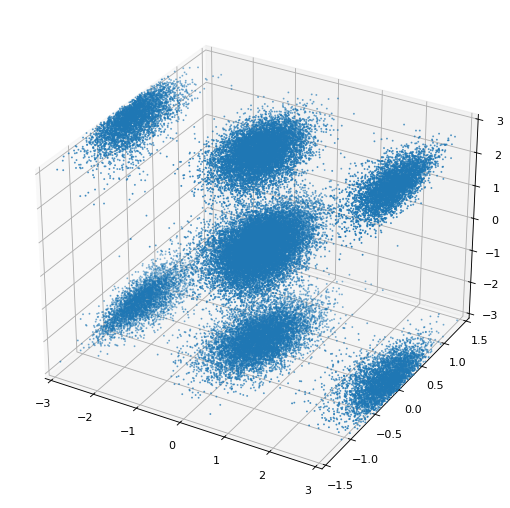

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Load toy dataset
data = np.load('data/orthogonal_group.npy')
print('size of toy dataset: ', len(data))

fig = plot_so3(data)
plt.savefig('figs/so3_synthetic_data.png', dpi=300)
plt.show()

### Dataloader

In [6]:
# load data
trainset = SpecialOrthogonalGroup(split="train")
trainloader = DataLoader(
    trainset, batch_size=1024, shuffle=True, num_workers=0
)

valset = SpecialOrthogonalGroup(split="valid")
valloader = DataLoader(
    valset, batch_size=256, shuffle=False, num_workers=0
)

testset = SpecialOrthogonalGroup(split="test")
testloader = DataLoader(
    testset, batch_size=256, shuffle=False, num_workers=0
)

### Stochastic OT CFM

This is a stochastic SO(3) OTCFM. 
The flow is calculated at a sample drawn an approximation of the conditional probability path: 

 $\hat{\rho}_t(\tilde{r}_t|r_0, r_1) = \mathcal{IG}_\mathrm{SO(3)}\Big(\tilde{r}_t; \exp_{r_0}(t \log_{r_0}(r_1)), \gamma^2(t) t(1-t)\Big)$

In [7]:
so3_group = SpecialOrthogonal(n=3, point_type="matrix")
FM = SO3SFM(manifold=so3_group) 

### Loss Functions

The final loss corresponds to equation (8) in the paper:

$$ \mathcal{L}_{\mathrm{sfm}-\mathrm{SO(3)}}(\theta) = \mathbb{E}_{t\sim \mathcal{U}(0,1), \bar{\pi}(r_0, r_1), \rho_t(\tilde{r}_t | r_0, r_1)} \left \|v_\theta(t, \tilde{r}_t) - \log_{\tilde{r}_t}(r_0)/t \right\|_{\mathrm{SO(3)}}^2.$$

In [8]:
def cfm_loss(v1, v2, x):
    res = v1 - v2
    norm = norm_SO3(x, res)
    loss = torch.mean(norm, dim=-1)
    return loss

In [29]:
_QUAT_MULTIPLY = np.zeros((4, 4, 4))
_QUAT_MULTIPLY[:, :, 0] = [[ 1, 0, 0, 0],
                          [ 0,-1, 0, 0],
                          [ 0, 0,-1, 0],
                          [ 0, 0, 0,-1]]

_QUAT_MULTIPLY[:, :, 1] = [[ 0, 1, 0, 0],
                          [ 1, 0, 0, 0],
                          [ 0, 0, 0, 1],
                          [ 0, 0,-1, 0]]

_QUAT_MULTIPLY[:, :, 2] = [[ 0, 0, 1, 0],
                          [ 0, 0, 0,-1],
                          [ 1, 0, 0, 0],
                          [ 0, 1, 0, 0]]

_QUAT_MULTIPLY[:, :, 3] = [[ 0, 0, 0, 1],
                          [ 0, 0, 1, 0],
                          [ 0,-1, 0, 0],
                          [ 1, 0, 0, 0]]

_QUAT_MULTIPLY_BY_VEC = _QUAT_MULTIPLY[:, 1:, :]


def quat_multiply(quat1, quat2):
    """Multiply a quaternion by another quaternion."""
    mat = quat1.new_tensor(_QUAT_MULTIPLY)
    reshaped_mat = mat.view((1,) * len(quat1.shape[:-1]) + mat.shape)
    return torch.sum(
        reshaped_mat *
        quat1[..., :, None, None] *
        quat2[..., None, :, None],
        dim=(-3, -2)
      )


def quat_multiply_by_vec(quat, vec):
    """Multiply a quaternion by a pure-vector quaternion."""
    mat = quat.new_tensor(_QUAT_MULTIPLY_BY_VEC)
    reshaped_mat = mat.view((1,) * len(quat.shape[:-1]) + mat.shape)
    return torch.sum(
        reshaped_mat *
        quat[..., :, None, None] *
        vec[..., None, :, None],
        dim=(-3, -2)
    )
    
def standardize_quaternion(quaternions: torch.Tensor) -> torch.Tensor:
    """
    Convert a unit quaternion to a standard form: one in which the real
    part is non negative.

    Args:
        quaternions: Quaternions with real part first,
            as tensor of shape (..., 4).

    Returns:
        Standardized quaternions as tensor of shape (..., 4).
    """
    return torch.where(quaternions[..., 0:1] < 0, -quaternions, quaternions)

### SDE Inference

In [39]:
from torch import nn

def final_init_(weights):
    with torch.no_grad():
        weights.fill_(0.0)

class Linear(nn.Linear):
    """
    A Linear layer with built-in nonstandard initializations. Called just
    like torch.nn.Linear.

    Implements the initializers in 1.11.4, plus some additional ones found
    in the code.
    """

    def __init__(
        self,
        in_dim: int,
        out_dim: int,
        bias: bool = True,
        init: str = "default",
        init_fn = None,
    ):
        """
        Args:
            in_dim:
                The final dimension of inputs to the layer
            out_dim:
                The final dimension of layer outputs
            bias:
                Whether to learn an additive bias. True by default
            init:
                The initializer to use. Choose from:

                "default": LeCun fan-in truncated normal initialization
                "relu": He initialization w/ truncated normal distribution
                "glorot": Fan-average Glorot uniform initialization
                "gating": Weights=0, Bias=1
                "normal": Normal initialization with std=1/sqrt(fan_in)
                "final": Weights=0, Bias=0

                Overridden by init_fn if the latter is not None.
            init_fn:
                A custom initializer taking weight and bias as inputs.
                Overrides init if not None.
        """
        super(Linear, self).__init__(in_dim, out_dim, bias=bias)

        if bias:
            with torch.no_grad():
                self.bias.fill_(0)

        if init_fn is not None:
            init_fn(self.weight, self.bias)
        else:
            if init == "final":
                final_init_(self.weight)
            else:
                raise ValueError("Invalid init string.")

In [ ]:
import utils.rotation_conversions as rc
from utils.bfn_base import bfnBase
import torch
from tqdm import trange

# MLP with tangential projection of the output to the tangent space of the input
class PMLP(torch.nn.Module):
    def __init__(self, dim, out_dim=None, w=64, time_varying=False):
        super().__init__()
        self.time_varying = time_varying
        if out_dim is None:
            out_dim = dim
        self.net = torch.nn.Sequential(
            torch.nn.Linear(dim + (1 if time_varying else 0), w),
            torch.nn.SELU(),
            torch.nn.Linear(w, w),
            torch.nn.SELU(),
            torch.nn.Linear(w, w),
            torch.nn.SELU(),
            torch.nn.Linear(w, out_dim),
        )
        # self.net = torch.nn.Sequential(
        #     Linear(dim + (1 if time_varying else 0), w, bias=True, init="final"),
        #     torch.nn.SELU(),
        #     Linear(w, w, bias=True, init="final"),
        #     torch.nn.SELU(),
        #     Linear(w, w, bias=True, init="final"),
        #     torch.nn.SELU(),
        #     Linear(w, out_dim,bias=True, init="final"),
        # )

    def forward(self, input):
        out = self.net(input)
        x = input[:, :4]
        # out = quat_multiply_by_vec(x, out)        
        out = out + x
        out = out / torch.norm(out, dim=-1, keepdim=True)
        # # 第一个维度一定是正数
        # out = standardize_quaternion(out)
        return out


    def tangent_space_proj(self, R, M):
        """
        Project the given 3x3 matrix M onto the tangent space of SO(3) at point R in PyTorch.

        Args:
        - M (torch.Tensor): 3x3 matrix from R^9
        - R (torch.Tensor): 3x3 matrix from SO(3) representing the point of tangency

        Returns:
        - T (torch.Tensor): projected 3x3 matrix in the tangent space of SO(3) at R
        """
        # Compute the skew-symmetric part of M
        skew_symmetric_part = 0.5 * (M - M.permute(0, 2, 1))

        # Project onto the tangent space at R
        T = R @ skew_symmetric_part

        return T

def net_pred(net, x_t, t, acc_quat):
    vt = net(torch.cat([
                # rearrange(x_t, 'b (c d) -> b c d', c=3, d=3),
                x_t,
                acc_quat,
                t], dim=-1))
    return vt
    
dim = 4 + 1  # network ouput is 9 dimensional (3x3 matrix)

beta1_quat = torch.tensor(1e3)

n_steps = 10
epsilon = 1e-7

BFN = bfnBase()

# MLP with a projection at the end, projection on to the tanget space of the manifold
vfield_net = PMLP(dim=dim, out_dim=4, time_varying=True).to(device).double()
optimizer = torch.optim.Adam(vfield_net.parameters(), lr=5e-5)

def main_loop(model, optimizer, num_epochs=150, display=True):
    losses = []
    w1ds = []
    w2ds = []

    for epoch in trange(num_epochs,desc='Training'):

        # if display:
        #     progress_bar = tqdm(total=len(trainloader))
        #     progress_bar.set_description(f"Epoch {epoch}")

        # if (epoch % 10) == 0:
        #     final_traj = inference(model)

        #     w_d1 = wasserstein(torch.tensor(testset.data).to(device).double().detach(), final_traj.detach(), power=1)
        #     w_d2 = wasserstein(torch.tensor(testset.data).to(device).double().detach(), final_traj.detach(), power=2)
        #     w1ds.append(w_d1)
        #     w2ds.append(w_d2)

        #     if display:
        #         plot_so3(final_traj)
        #         plt.show()
        #         print('wassterstein-1 distance:', w_d1)
        #         print('wassterstein-2 distance:', w_d2)


        for _, data in enumerate(trainloader):
            optimizer.zero_grad()
            rotmat_1 = data.to(device)
            quat_1 = rc.matrix_to_quaternion(rotmat_1)
            quat_1 = quat_1.unsqueeze(1)

            num_batch = quat_1.size(0)
            
            t = torch.randint(0, n_steps,size=(num_batch,1), 
                            device=rotmat_1.device)/n_steps 
            t_index = t * n_steps + 1   
            
            # add noise         
            m_quat_t, acc_quat_t = BFN.sphere_var_bayesian_flow_sim(
                x=quat_1, t_index=t_index, beta1 = beta1_quat, N=n_steps, epsilon=epsilon
            )

            # pred_rotaxis_1, pred_rotang_1 = net_pred(
            #     model, rotmat_t.reshape(-1,9), t, acc_quat_t.squeeze(-1), acc_rotang_t.squeeze(-1))
            
            pred_quat = net_pred(model, m_quat_t.squeeze(dim=1), t,  acc_quat_t.squeeze(dim=1))

            loss = BFN.dtime4sphere_loss(
                x=quat_1.squeeze().float(), 
                x_pred=pred_quat.squeeze(),
                t_index=t_index,
                beta1=beta1_quat,
                N=n_steps,
                do_weight_norm=False,
                p=4
            )

            losses.append(loss.detach().cpu().numpy())
            loss.backward()
            optimizer.step()

            # if display:
            #     progress_bar.update(1)
            #     logs = {"loss": loss.detach().item(), "step": global_step}
            #     progress_bar.set_postfix(**logs)
            #     global_step += 1

    return model, np.array(losses), np.array(w1ds), np.array(w2ds)

vfield_net, losses, w1s, w2s = main_loop(vfield_net, optimizer, num_epochs=50, display=False)

plt.plot(losses)

Training:  49%|████▉     | 49/100 [02:24<02:33,  3.02s/it]

100%|██████████| 10/10 [00:02<00:00,  4.28it/s]


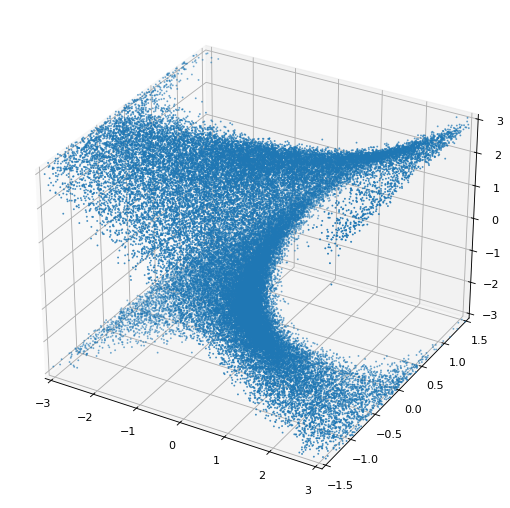

In [66]:
def inference(vfield_net, n_test=None):
    with torch.no_grad():
        if n_test is None:
            n_test = testset.data.shape[0]

        rotmat_t = torch.tensor(Rotation.random(n_test).as_matrix()).to(device)
        m_quat_t = rc.matrix_to_quaternion(rotmat_t)
        acc_quat_t = torch.zeros(size=(n_test,1), device=device)
        for time_index in trange(1, n_steps+1):
            t = (time_index-1) * torch.ones(size=(n_test,1), device=device)/n_steps 
            t_index = t * n_steps + 1
            
            pred_quat = net_pred(vfield_net, m_quat_t, t, acc_quat_t)
          
            # bayesian update
            alpha_quat = BFN.sphere_alpha_wrt_index(t_index, N=n_steps, beta1=beta1_quat, p=4)
            
            m_quat_t, acc_quat_t = BFN.sphere_var_bayesian_update(
                loc_prev=m_quat_t, conc_prev=BFN.sphere_denorm_conc(acc_quat_t, beta1=beta1_quat),
                alpha_i=alpha_quat, pred_x=pred_quat)
            acc_quat_t = BFN.sphere_norm_log_conc(acc_quat_t.log(), beta1=beta1_quat)
    
    rotmat = rc.quaternion_to_matrix(pred_quat)
    
    return rotmat

# inference on the full dataset for visualization
plt.style.use('default')
n_test = 50000
traj = inference(vfield_net, n_test=n_test)

fig = plot_so3(traj)
plt.show()

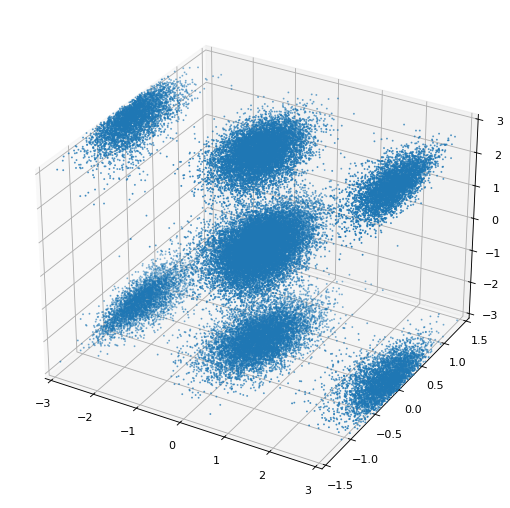

In [61]:
fig = plot_so3(data)